In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
  import torch
  import foolbox
except ImportError:
  %pip install git+https://gitlab.com/secml/secml#egg=secml[pytorch,foolbox]

In [2]:
random_state = 999

n_tr = 500  # Number of training set samples
n_ts = 500  # Number of test set samples

from secml.data.loader import CDataLoaderMNIST
loader = CDataLoaderMNIST()
tr = loader.load('training', num_samples=n_tr)
ts = loader.load('testing', num_samples=n_ts)

# Normalize the features in `[0, 1]`
tr.X /= 255
ts.X /= 255

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF

clf = CClassifierMulticlassOVA( CClassifierSVM, kernel=CKernelRBF(gamma=1e-2))

print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Training of classifier...
Accuracy on test set: 83.80%


In [3]:
from secml.explanation import \
    CExplainerGradient, CExplainerGradientInput, CExplainerIntegratedGradients

explainers = (
    {
        'exp': CExplainerGradient(clf),  # Gradient
        'label': 'Gradient'
    },
    {
        'exp': CExplainerGradientInput(clf),  # Gradient * Input
        'label': 'Grad*Input'
    },
    {
        'exp': CExplainerIntegratedGradients(clf),  # Integrated Gradients
        'label': 'Int. Grads'
    },
)


In [4]:
i = 123  # Test sample on which explanations should be computed
x, y = ts[i, :].X, ts[i, :].Y

print("Explanations for sample {:} (true class: {:})".format(i, y.item()))

from secml.array import CArray

for expl in explainers:

    print("Computing explanations using '{:}'...".format(
        expl['exp'].__class__.__name__))

    # Compute explanations (attributions) wrt each class
    attr = CArray.empty(shape=(tr.num_classes, x.size))
    for c in tr.classes:

        attr_c = expl['exp'].explain(x, y=c)
        attr[c, :] = attr_c

    expl['attr'] = attr

Explanations for sample 123 (true class: 6)
Computing explanations using 'CExplainerGradient'...
Computing explanations using 'CExplainerGradientInput'...
Computing explanations using 'CExplainerIntegratedGradients'...


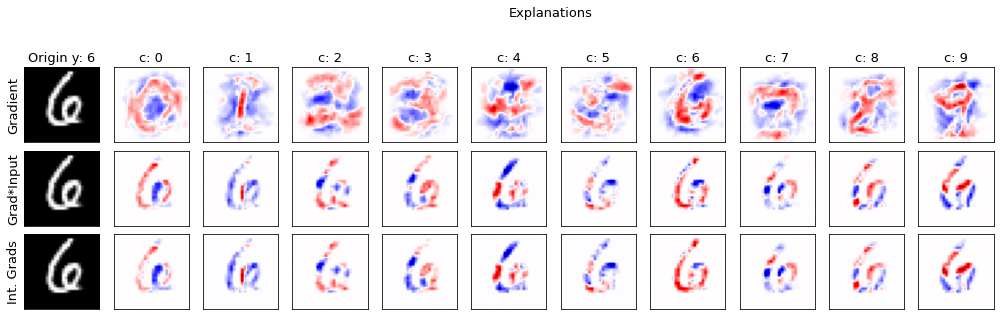

In [5]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=4.5, width=14, fontsize=13)

for i, expl in enumerate(explainers):

    sp_idx = i * (tr.num_classes+1)

    # Original image
    fig.subplot(len(explainers), tr.num_classes+1, sp_idx+1)
    fig.sp.imshow(x.reshape((tr.header.img_h, tr.header.img_w)), cmap='gray')

    if i == 0:  # For the first row only
        fig.sp.title("Origin y: {:}".format(y.item()))

    fig.sp.ylabel(expl['label'])  # Label of the explainer

    fig.sp.yticks([])
    fig.sp.xticks([])

    # Threshold to plot positive and negative relevance values symmetrically
    th = max(abs(expl['attr'].min()), abs(expl['attr'].max()))

    # Plot explanations
    for c in tr.classes:

        fig.subplot(len(explainers), tr.num_classes+1, sp_idx+2+c)
        fig.sp.imshow(expl['attr'][c, :].reshape((tr.header.img_h, tr.header.img_w)),
                      cmap='seismic', vmin=-1*th, vmax=th)

        fig.sp.yticks([])
        fig.sp.xticks([])

        if i == 0:  # For the first row only
            fig.sp.title("c: {:}".format(c))

fig.title("Explanations", x=0.55)
fig.tight_layout(rect=[0, 0.003, 1, 0.94])
fig.show()

In [6]:
from secml.explanation import CExplainerInfluenceFunctions

explanation = CExplainerInfluenceFunctions(
    clf, tr, outer_loss_idx='hinge')  # SVM loss is 'hinge'

print("Computing influence of each training prototype on test samples...")

infl = explanation.explain(ts.X, ts.Y)

print("Done.")

Computing influence of each training prototype on test samples...


NotImplementedError: 